# TimesFM 2.5 Example

This notebook demonstrates the basic usage of TimesFM 2.5 (200M parameters) for time series forecasting.


In [1]:
import torch
import numpy as np
import timesfm
import matplotlib.pyplot as plt


## Set Float32 Precision and Load Model

We'll load the pretrained TimesFM 2.5 200M model from HuggingFace.


In [2]:
torch.set_float32_matmul_precision("high")

model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")


## Configure the Model

Set the forecast configuration with parameters like context length, horizon, and quantile forecasting options.


In [3]:
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=256,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)


## Prepare Input Data

We'll create two dummy time series:
1. A linear trend from 0 to 1
2. A sinusoidal pattern


In [4]:
point_forecast, quantile_forecast = model.forecast(
    horizon=12,
    inputs=[
        np.linspace(0, 1, 100),
        np.sin(np.linspace(0, 20, 67)),
    ],  # Two dummy inputs
)
print(f"Point forecast shape: {point_forecast.shape}")  # (2, 12)
print(f"Quantile forecast shape: {quantile_forecast.shape}")  # (2, 12, 10): mean, then 10th to 90th quantiles.


Point forecast shape: (2, 12)
Quantile forecast shape: (2, 12, 10)


## Visualize Results

Let's plot the input series and their forecasts with confidence intervals.


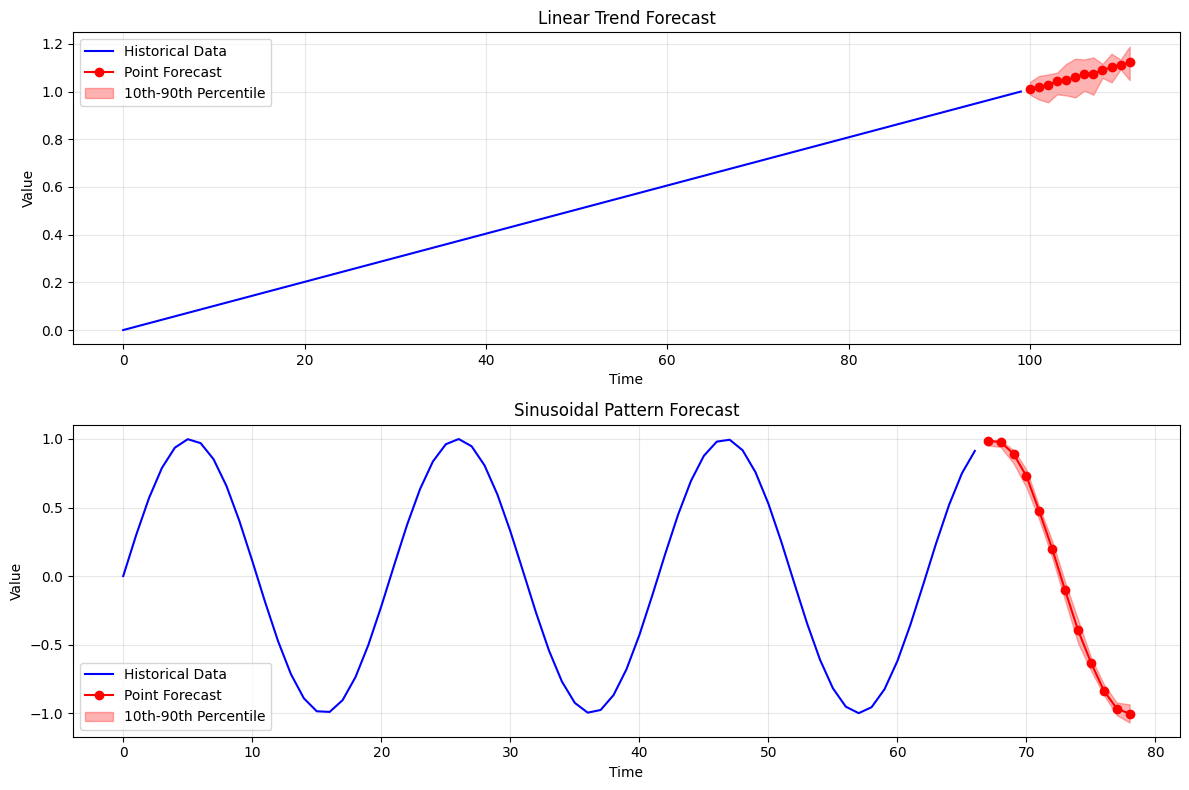

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Prepare the inputs again for plotting
input1 = np.linspace(0, 1, 100)
input2 = np.sin(np.linspace(0, 20, 67))

# Plot first series
ax1 = axes[0]
ax1.plot(range(len(input1)), input1, label='Historical Data', color='blue')
forecast_start = len(input1)
forecast_range = range(forecast_start, forecast_start + 12)
ax1.plot(forecast_range, point_forecast[0], label='Point Forecast', color='red', marker='o')

# Add confidence intervals (10th and 90th percentiles)
ax1.fill_between(
    forecast_range, 
    quantile_forecast[0, :, 1],  # 10th percentile
    quantile_forecast[0, :, -1],  # 90th percentile
    alpha=0.3, 
    color='red',
    label='10th-90th Percentile'
)
ax1.set_title('Linear Trend Forecast')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot second series
ax2 = axes[1]
ax2.plot(range(len(input2)), input2, label='Historical Data', color='blue')
forecast_start = len(input2)
forecast_range = range(forecast_start, forecast_start + 12)
ax2.plot(forecast_range, point_forecast[1], label='Point Forecast', color='red', marker='o')

# Add confidence intervals
ax2.fill_between(
    forecast_range, 
    quantile_forecast[1, :, 1],  # 10th percentile
    quantile_forecast[1, :, -1],  # 90th percentile
    alpha=0.3, 
    color='red',
    label='10th-90th Percentile'
)
ax2.set_title('Sinusoidal Pattern Forecast')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
